In [1]:
from pypetri.elements import *
from pypetri.petri_net import *
from pypetri.example_nets import *
import math

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import collections
import random

from tqdm import tqdm


In [2]:
class ReplayBuffer():
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done
    
    def size(self):
        return len(self.buffer)
        

In [3]:
class P2P(nn.Module):
    def __init__(self, dim_in, dim_out, adj_pt, f=F.leaky_relu):
        super(P2P, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(dim_out, dim_in).float())
        self.bias = nn.Parameter(torch.Tensor(dim_out).float())
        self.f = f
        self.adj_pt = adj_pt
        self.pm = torch.matmul(self.adj_pt, self.adj_pt.t())
        self.batch_norm = nn.BatchNorm1d(dim_out)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, x):
        x = torch.matmul(self.pm, x)
        diag = self.pm.diagonal().unsqueeze(0).unsqueeze(2)
        x = x / diag
        x = torch.matmul(x, self.weight.t()) + self.bias.unsqueeze(0)
        
        batch_size, Np, dim_out = x.size()
        x = x.view(-1, dim_out)
        x = self.batch_norm(x)
        x = x.view(batch_size, Np, dim_out) 
        
        x = self.f(x)
        return x
    
class T2T(nn.Module):
    def __init__(self, dim_in, dim_out, adj_pt, f=F.leaky_relu):
        super(T2T, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(dim_out, dim_in).float())
        self.bias = nn.Parameter(torch.Tensor(dim_out).float())
        self.f = f
        self.adj_pt = adj_pt
        self.pm = torch.matmul(self.adj_pt.t(), self.adj_pt)
        self.batch_norm = nn.BatchNorm1d(dim_out)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, x):
        x = torch.matmul(self.pm, x)
        
        diag = self.pm.diagonal()+1
        diag = diag.unsqueeze(0).unsqueeze(2)
        x = x / diag
        x = torch.matmul(x, self.weight.t()) + self.bias.unsqueeze(0)
        
        batch_size, Np, dim_out = x.size()
        x = x.view(-1, dim_out)
        x = self.batch_norm(x)
        x = x.view(batch_size, Np, dim_out) 
        
        x = self.f(x)
        return x
    
class T2P(nn.Module):
    def __init__(self, dim_in, dim_out, adj_pt, f=F.leaky_relu, add_bias=True):
        super(T2P, self).__init__()
        self.adj_pt = adj_pt
        self.f = f
        self.weight = nn.Parameter(torch.Tensor(dim_out, dim_in).float())
        self.bias = nn.Parameter(torch.Tensor(dim_out).float())
        self.add_bias = add_bias
        self.batch_norm = nn.BatchNorm1d(dim_out)
        
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
            
    def forward(self, x):
        x = torch.matmul(self.adj_pt, x)
        x = torch.matmul(x, self.weight.t())
        if self.add_bias:
            x = x + self.bias.unsqueeze(0)
            
        batch_size, Np, dim_out = x.size()
        x = x.view(-1, dim_out)
        x = self.batch_norm(x)
        x = x.view(batch_size, Np, dim_out) 
            
        x = self.f(x)
        return x
        
class P2T(nn.Module):
    def __init__(self, dim_in, dim_out, adj_pt, f=F.leaky_relu, add_bias=True):
        super(P2T, self).__init__()
        self.adj_pt = adj_pt
        self.f = f
        self.weight = nn.Parameter(torch.Tensor(dim_out, dim_in).float())
        self.bias = nn.Parameter(torch.Tensor(dim_out).float())
        self.add_bias = add_bias
        self.batch_norm = nn.BatchNorm1d(dim_out)
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
        
    def forward(self, x):
        x = torch.matmul(self.adj_pt.t(), x)
        x = torch.matmul(x, self.weight.t())
        if self.add_bias:
            x = x + self.bias.unsqueeze(0)
            
        batch_size, Np, dim_out = x.size()
        x = x.view(-1, dim_out)
        x = self.batch_norm(x)
        x = x.view(batch_size, Np, dim_out) 
        
        x = self.f(x)
        return x
        

In [4]:
class GCPN_layer(torch.nn.Module):
    def __init__(self, lp_in, lt_in, lp_out, lt_out, adj_matrix):
        super(GCPN_layer, self).__init__()
        self.P2P = P2P(lp_in, lp_out, adj_matrix)
        self.T2T = T2T(lt_in, lt_out, adj_matrix)
        self.P2T = P2T(lp_out, lt_out, adj_matrix)
        self.T2P = T2P(lt_out, lp_out, adj_matrix)
        
    def forward(self, p, t):
        p1 = self.P2P(p)
        t1 = self.T2T(t)
        
        dt = self.P2T(p1)
        t2 = t1 + dt
        
        dp = self.T2P(t2)
        p2 = p1 + dp
        
        return p2, t2

In [5]:
class GPNQNet(torch.nn.Module):
    def __init__(self, lp0, lt0, adj_matrix, device):
        super(GPNQNet, self).__init__()
        self.adj_matrix = torch.from_numpy(adj_matrix).float().to(device)
        
        self.gcpn_1 = GCPN_layer(lp0, lt0, 8, 8, self.adj_matrix)
        self.gcpn_2 = GCPN_layer(8, 8, 16, 16, self.adj_matrix)
        self.gcpn_3 = GCPN_layer(16, 16, 64, 64, self.adj_matrix)
        self.gcpn_4 = GCPN_layer(64, 64, 16, 16, self.adj_matrix)
        self.gcpn_5 = GCPN_layer(16, 16, 1, 1, self.adj_matrix)
        

    def forward(self, p, t):
        if isinstance(p, np.ndarray):
            p = torch.from_numpy(p).float()
        if isinstance(t, np.ndarray):
            t = torch.from_numpy(t).float()
        p1, t1 = self.gcpn_1(p, t)
        p2, t2 = self.gcpn_2(p1, t1)
        p3, t3 = self.gcpn_3(p2, t2)
        p4, t4 = self.gcpn_4(p3, t3)
        _, tf = self.gcpn_5(p4, t4)
        
        return tf
        

In [6]:
class DQN:
    def __init__(self, lp, lt, action_dim, adj_matrix, learning_rate, gamma, epsilon, epsilon_min, epsilon_decay, target_update, device):
        self.lp = lp
        self.lt = lt
        self.action_dim = action_dim
        self.q_net = GPNQNet(lp, lt, adj_matrix, device).to(device)
        self.target_q_net = GPNQNet(lp, lt, adj_matrix, device).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.target_update = target_update
        self.device = device
        self.count = 0
        
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            action = np.random.randint(0, self.action_dim)
        else:
            state_p = state[0]
            state_l = state[1]
            state_p = torch.tensor([state_p], dtype=torch.float).to(self.device)
            state_l = torch.tensor([state_l], dtype=torch.float).to(self.device)
            action = self.q_net(state_p, state_l).argmax().item()
        return action
        
    def update(self, transition_dict):
        # print(transition_dict['states'][:, 0])
        p_states = torch.tensor([transition_dict['states'][:, 0]], dtype=torch.float).squeeze(0).to(self.device)
        t_states = torch.tensor([transition_dict['states'][:, 1]], dtype=torch.float).squeeze(0).to(self.device)
        
        actions = torch.tensor([transition_dict['actions']]).view(-1, 1).unsqueeze(-1).to(self.device)
        rewards = torch.tensor([transition_dict['rewards']], dtype=torch.float).view(-1, 1).to(self.device)
        
        next_p_states = torch.tensor([transition_dict['next_states'][:, 0]], dtype=torch.float).squeeze(0).to(self.device)
        next_t_states = torch.tensor([transition_dict['next_states'][:, 1]], dtype=torch.float).squeeze(0).to(self.device)
        dones = torch.tensor([transition_dict['dones']], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(p_states, t_states)
        q_values = q_values.gather(1, actions)
        max_next_q_values = self.target_q_net(next_p_states, next_t_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        loss = torch.mean(F.mse_loss(q_values, q_targets))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

In [7]:

lr = 5e-3
gamma = 0.98
epsilon = 0.1
epsilon_min = 0.01
epsilon_decay = 0.99
num_episode = 500
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 128

efm_net = EmptyNet('efm_net')
initial_file_path = 'initial_file/neural_petri_net.csv'
efm_net.init_by_csv(initial_file_path)
efm_net.set_dt(1)

lp = efm_net.get_state()[0].shape[1]
lt = efm_net.get_state()[1].shape[1]
action_dim = efm_net.get_action_space()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
agent = DQN(lp, lt, action_dim, efm_net.get_adj_matrix(), lr, gamma, epsilon, epsilon_min, epsilon_decay, target_update, device)

cuda


In [8]:

return_list = []
action_list = []
for i in range(500):
    with tqdm(total=int(num_episode / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episode / 10)):
            episode_return = 0
            state = efm_net.reset()
            done = False
            this_action = []
            
            while not done:
                action = agent.take_action(state)
                this_action.append(action)
                next_state, reward, done = efm_net.step(action)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state

                episode_return += reward

                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {'states': b_s, 'actions': b_a, 'rewards': b_r, 'next_states': b_ns, 'dones': b_d}
                    agent.update(transition_dict)

                if efm_net.train_time > 100:
                    done = True
                        
            
            return_list.append(episode_return)
            
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episode / 10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                action_list.append(this_action)
            pbar.update(1)
    if (i+1) % 10 == 0:
        torch.save(agent.q_net.state_dict(), 'model/GCPN_5Layer_L.pth')

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\87903\AppData\Local\Temp\ipykernel_35704\2706762323.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:210.)
  state_p = torch.tensor([state_p], dtype=torch.float).to(self.device)
Iteration 0:   8%|▊         | 4/50 [00:03<00:41,  1.11it/s]C:\Users\87903\AppData\Local\Temp\ipykernel_35704\846506765.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(state), action, reward, np.array(next_state), done
C:\Users\87903\AppData\Local\Temp\ipykernel_35704\2706762323.py:46: UserWarning: Using a t

[-5.999999999999982, -313.36, -238.51, -423.14, -108.77000000000001, -468.04999999999995, -303.37999999999965, -391.19000000000005, -188.61, -178.6299999999998, -248.4899999999998, -493.0, -318.3499999999997, -358.27, -263.4599999999998, -283.41999999999996, -298.3899999999999, -311.35, -153.68000000000012, -228.52999999999986, -218.5499999999999, -253.47999999999973, -223.53999999999996, -188.60999999999987, -318.3499999999997, -313.3599999999998, -323.3399999999998, -258.46999999999974, -393.1999999999998, -463.06, -493.0, -483.02, -493.0, -493.0, -493.0, -493.0, -493.0, -493.0, -488.01, -493.0, -493.0, -493.0, -493.0, -493.0, -493.0, -493.0, -493.0, -253.47999999999956, -273.4399999999998, -148.68999999999997, -228.53, -178.63, -163.65999999999994, -133.72000000000003, -287.36, -279.38999999999976, -258.46999999999963, -118.74999999999999, -373.24, -113.76000000000005, -148.69000000000005, -198.58999999999992, -322.28999999999974, -223.5399999999996, -153.67999999999986, -108.770000

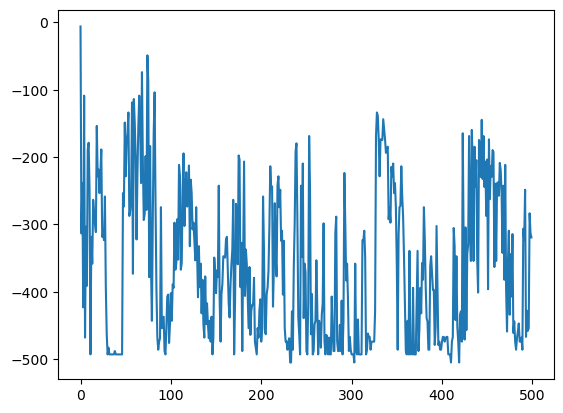

In [24]:
print(return_list)
plt.plot(range(len(return_list)), return_list)

In [25]:
import csv

result_path = 'result0918_L.csv'

with open(result_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(return_list)
    
    

In [26]:
action_path = 'action0918_L.csv'

with open(action_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(action_list)

In [27]:
import importlib
from rltk import rl_utils

importlib.reload(rl_utils)

<module 'rltk.rl_utils' from 'e:\\SJTU_pro\\DigitalTwin\\dtg_ws\\pntk\\rltk\\rl_utils.py'>

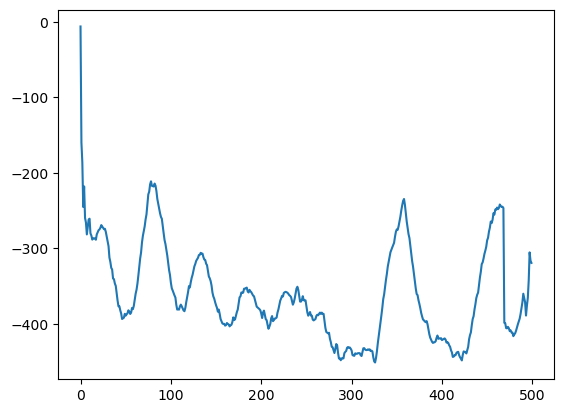

In [28]:
mv_return = rl_utils.window_average(return_list, 32)
plt.plot(range(len(return_list)), mv_return)

In [29]:
prob = -19
# print(return_list[prob:])
# print(len(action_list[prob]))
# print(action_list[prob])

In [30]:
state = efm_net.get_state()
action = agent.take_action(state)
state_p = state[0]
state_t = state[1]
state_p = torch.tensor([state_p], dtype=torch.float).to(device)
state_t = torch.tensor([state_t], dtype=torch.float).to(device)
output = agent.q_net(state_p, state_t)
print(output, action)

tensor([[[-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.1973],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
         [-2.0539],
